## Classificação Binária com Random Forest - Sonar Dataset
Neste notebook, vamos treinar uma árvore de decisão, criar um ensemble manual estilo Random Forest, e comparar com o `RandomForestClassifier` do `scikit-learn`, usando o desafiador Sonar Dataset.

In [8]:
# 1. Carregamento e pré-processamento do Sonar Dataset
from sklearn.datasets import fetch_openml
import pandas as pd

data = fetch_openml(name='sonar', version=1, as_frame=True)
X = data.data
y = data.target

# Converter o target para 0 (rock) e 1 (mine)
y = y.map({'Rock': 0, 'Mine': 1})

In [9]:
# 2. Divisão em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [10]:
# 3. Árvore de decisão simples
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Árvore de Decisão (base):")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Árvore de Decisão (base):
[[21  8]
 [ 9 25]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        29
           1       0.76      0.74      0.75        34

    accuracy                           0.73        63
   macro avg       0.73      0.73      0.73        63
weighted avg       0.73      0.73      0.73        63



In [15]:
# 4. Ensemble Random Forest manual
import numpy as np
from collections import Counter

def manual_random_forest(X, y, X_test, n_estimators=100, sample_ratio=0.8, feature_ratio=0.8):
    n_samples = int(sample_ratio * len(X))
    n_features = int(feature_ratio * X.shape[1])
    trees = []
    features_list = []

    for _ in range(n_estimators):
        sample_idx = np.random.choice(X.index, size=n_samples, replace=True)
        X_sample = X.loc[sample_idx]
        y_sample = y.loc[sample_idx]

        feature_idx = np.random.choice(X.columns, size=n_features, replace=False)
        features_list.append(feature_idx)

        tree = DecisionTreeClassifier(max_depth=3)
        tree.fit(X_sample[feature_idx], y_sample)
        trees.append(tree)

    all_preds = []
    for tree, feat in zip(trees, features_list):
        preds = tree.predict(X_test[feat])
        all_preds.append(preds)

    all_preds = np.array(all_preds).T
    final_preds = [Counter(row).most_common(1)[0][0] for row in all_preds]
    return np.array(final_preds)

y_pred_manual_rf = manual_random_forest(X_train, y_train, X_test)

print("Random Forest Manual:")
print(confusion_matrix(y_test, y_pred_manual_rf))
print(classification_report(y_test, y_pred_manual_rf))

Random Forest Manual:
[[19 10]
 [ 5 29]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        29
           1       0.74      0.85      0.79        34

    accuracy                           0.76        63
   macro avg       0.77      0.75      0.76        63
weighted avg       0.77      0.76      0.76        63



In [16]:
# 5. RandomForestClassifier do scikit-learn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RandomForestClassifier (sklearn):")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

RandomForestClassifier (sklearn):
[[19 10]
 [ 4 30]]
              precision    recall  f1-score   support

           0       0.83      0.66      0.73        29
           1       0.75      0.88      0.81        34

    accuracy                           0.78        63
   macro avg       0.79      0.77      0.77        63
weighted avg       0.79      0.78      0.77        63



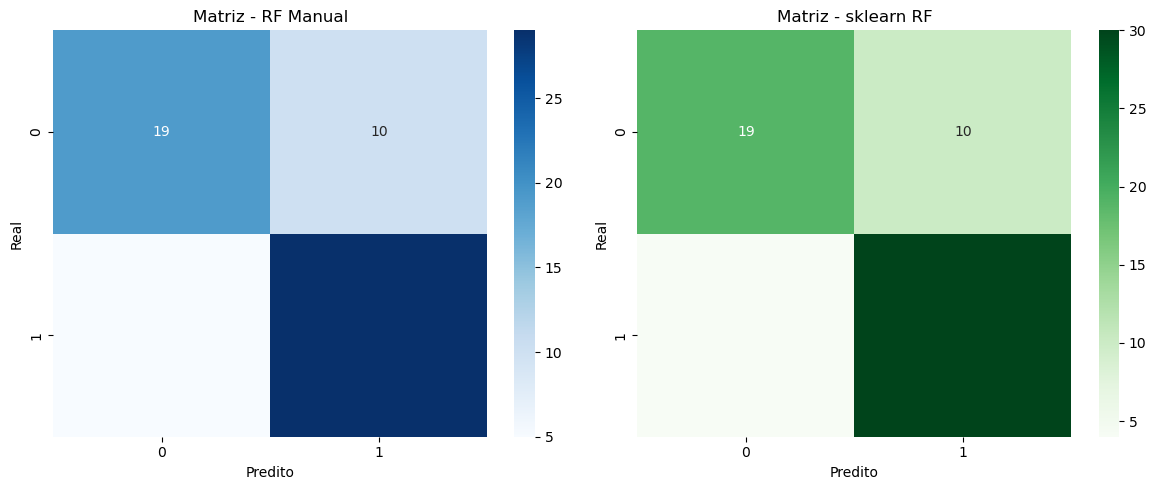

In [17]:
# 6. Matrizes de confusão visuais
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_manual_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz - RF Manual")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz - sklearn RF")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.tight_layout()
plt.show()